In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
# Hien thi tien trinh chay
from tqdm import tqdm
# Cac cong cu xu ly anh
#ImageGenerator: Tao du lieu anh voi augmentation
#load_img: Load anh tu file
#img+to_array: chuyen anh sang nupy array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# Cac cong cu xu ly van ban va chuoi
from tensorflow.keras.preprocessing.text import Tokenizer # Bien text thanh so
from tensorflow.keras.preprocessing.sequence import pad_sequences # Chuan hoa do dai chuoi
from tensorflow.keras.utils import to_categorical #One hot encoding cho nhan
#Khai bao mo hinh
from tensorflow.keras.models import Sequential, Model # Xay dung mo hinh tuan tu, MOdel: functional api
#Cac player xay dung mo hinh
#Conv2D,...:Cac player CNN dung trong xu ly anh
#Dropout: tranh1 overfitting
#Flatten, Dense, Activision: fully correctted players
#Embedding: chuyen tu word index sang vector
# LSTM, Bidirectional: mạng hồi tiếp cho chuỗi (caption)
# add, concatenate, Concatenate, Reshape: kết hợp và thay đổi hình dạng tensor
# Layer: lớp cơ bản để custom layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
#Cac mo hinh pretrain de trich xuat dac trung anh
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
#Optimizer
from tensorflow.keras.optimizers import Adam
#Callback ho tro qua trinh training
#Modelcheckpoint: Luu mo hinh tot nhat trong qua trinh huan luyen
#Earlystopping: dung som neu model ko vai thien
# ReduceLROnPlateau: giảm learning rate khi loss không giảm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#Xu ly text
from textwrap import wrap # Tu dong xuong dong
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] =12
sns.set_style("dark")

In [4]:
%cd '/content/drive/MyDrive/Hoc Sau/Image-Caption'

/content/drive/MyDrive/Hoc Sau/Image-Caption


In [5]:
image_path = 'Images'
data = pd.read_csv('captions.txt')

In [6]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


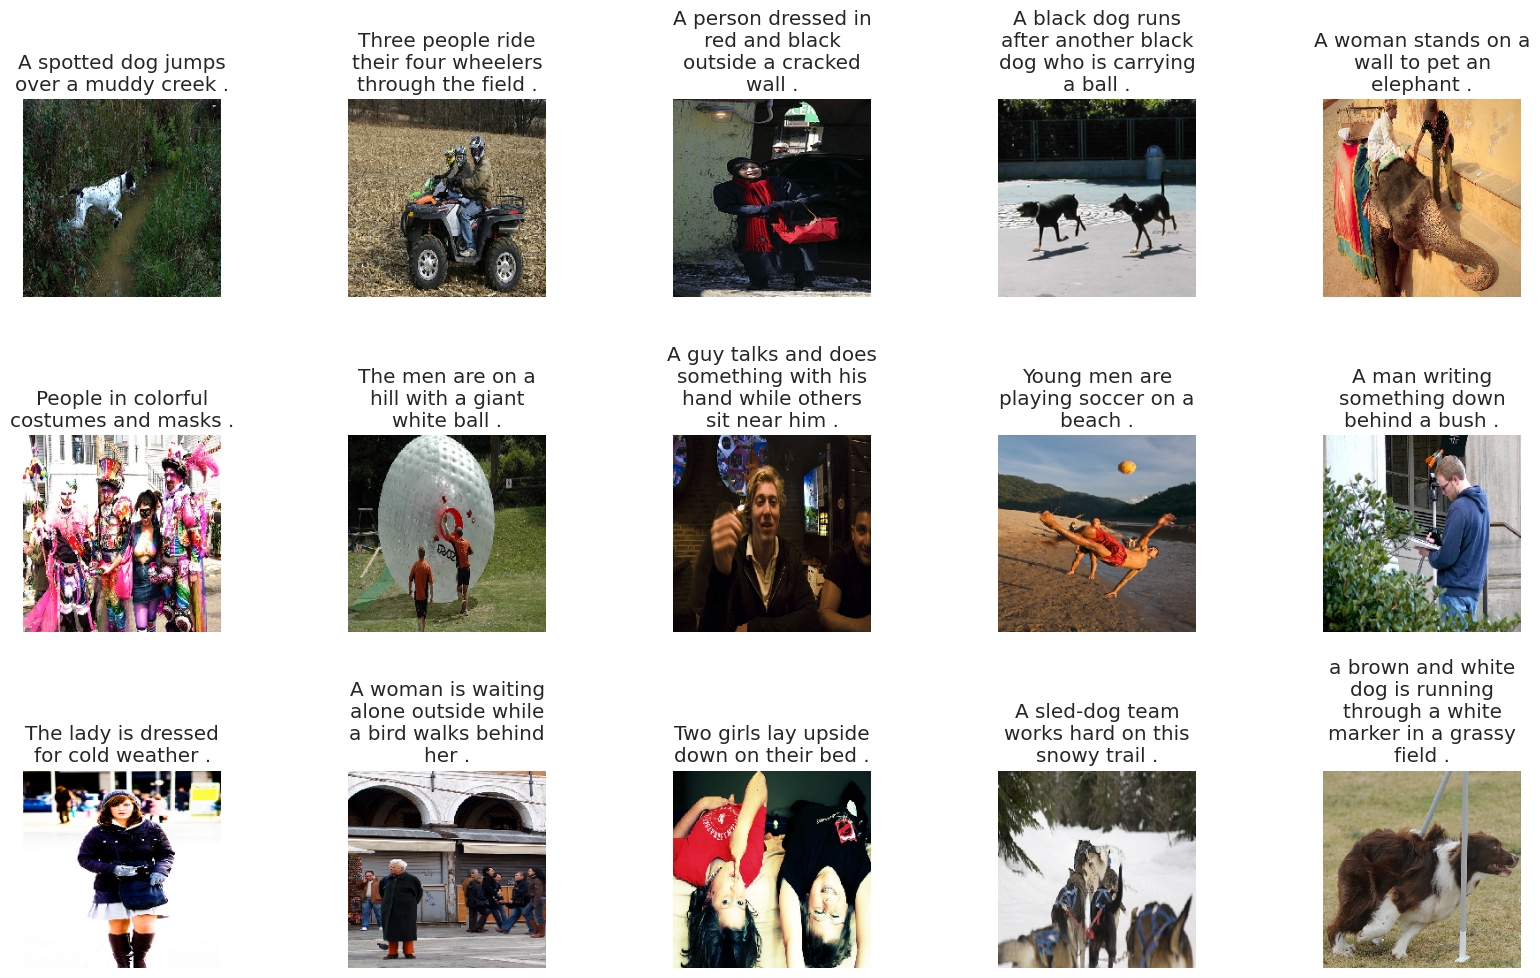

In [7]:

def readImage(path, img_size = 224):
  #Load anh tu duong dan, chuyen thanh rgb,  resize ve (224,224)
  img = load_img(path, color_mode = 'rgb', target_size= (img_size, img_size))
  #Chuyen anh thanh numpy array
  img = img_to_array(img)
  img = img/255 # 0 1
  return img

def display_images(temp_df):
  #Reset lai index da bao chay tu 0 den n-1
  temp_df = temp_df.reset_index(drop = True)
  #Tao figure kich thuoc lon 20x20
  plt.figure(figsize= (20, 20))
  n = 0
  for i in range(15): # Lap qua 15 anh
    n+=1
    plt.subplot(5,5,n)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3) #Chinh khoang cach giua cac o anh
    # Đọc ảnh từ thư mục "Images/", tên ảnh lấy từ cột temp_df.image
    image = readImage(f"Images/{temp_df.image[i]}")
    plt.imshow(image)
    # Đặt tiêu đề cho ảnh, caption được bọc dòng mỗi 20 ký tự
    plt.title("\n".join(wrap(temp_df.caption[i], 20)))
    plt.axis("off")


display_images(data.sample(15))


In [8]:
def text_preprocessing(data):
  #Chuyen toa bo caption sang chu thuong
  data['caption'] = data['caption'].apply(lambda x: x.lower())
  #Thay ky tu khong phai chu cai bang khoang3 trang
  data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", " "))
  #Thay nhieu khoang trang linen tiep bang 1 khoang trang
  data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
  #Loai bo tu co do dai bang 1
  data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
  #Them token dac biet
  data['caption'] = "startseq " + data['caption'] + " endseq"
  return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [9]:
#Khoi tao tokenizer de bien cac caption thanh chuoi so
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions) #Tim do dai lon nhat cua caption
#Se dung padding tat ca caption ve cung do dai sau nay
# Lấy danh sách ảnh duy nhất từ cột "image" (mỗi ảnh có thể có nhiều caption)
# Chuyển sang list Python
images = data['image'].unique().tolist()
#Tong so anh duy nhat
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)
# Biến caption thứ 2 trong danh sách captions thành chuỗi số (sequence)
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [10]:
#Tao model DenseNet201 pretrained
model = DenseNet201()
#Lay model fe vooi input la model goc, output l aplayer gan cuoi
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
# Dictionary để lưu đặc trưng (features) của từng ảnh
features = {}
#Lap qua tung nah  trong datset
for image in tqdm(data['image'].unique().tolist()):
  # Load ảnh và resize về kích thước (224, 224)
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
     # Thêm 1 chiều batch (1, H, W, C) để phù hợp với input của model
    img = np.expand_dims(img,axis=0)
    #Trích xuất đặc trưng từ ảnh bằng feature extractor
    feature = fe.predict(img, verbose=0)
    # Lưu feature vector vào dict theo tên ảnh
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [1:13:50<00:00,  1.83it/s]


In [11]:
from tensorflow.keras.utils import Sequence
#Ke thua tu keras sequence ( dung cho genetor )
class CustomDataGenerator(Sequence):
  def __init__(self, df, x_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle = True):
    # Lưu lại các tham số quan trọng
    self.df = df.copy()               # DataFrame chứa dữ liệu (image + caption)
    self.x_col = x_col                # Tên cột chứa ảnh
    self.y_col = y_col                # Tên cột chứa caption
    self.directory = directory        # Thư mục chứa ảnh
    self.batch_size = batch_size      # Batch size
    self.tokenizer = tokenizer        # Tokenizer đã train trên captions
    self.vocab_size = vocab_size      # Số lượng từ trong vocab
    self.max_length = max_length      # Độ dài caption max (dùng padding)
    self.features = features          # Feature vector đã trích xuất từ ảnh (DenseNet)
    self.shuffle = shuffle            # Có shuffle sau mỗi epoch hay không
    self.n = len(self.df)             # Số mẫu trong DataFrame
 #Ham nay duoc goi sau moi epoch
  def on_epoch_end(self):
    #Shuffle lai data de tranh overfiting
    if self.shuffle:
      self.df = self.df.sample(frac =1).reset_index(drop = True)
  #TRa ve so batch moi epoch
  def __len__(self):
    return self.n // self.batch_size

  def __getitem__(self, index):
    #Lay batch thu index
    batch = self.df.iloc[index* self.batch_size:(index + 1) * self.batch_size,:]
    # Trích xuất dữ liệu (ảnh và caption tokenized)
    x1, x2, y = self.__get_data(batch)
    # Trả về tuple ((features ảnh, chuỗi caption input), output caption next word)
    return (x1, x2), y
  #Ham score: chuyen anh + caption -> data chomodel
  def __get_data(self, batch):

    x1, x2, y = list(), list(), list()
    images = batch[self.x_col].tolist() #Lay danh sach anh trong batch
    for image in images: #Lay feature vector cua anh
      feature = self.features[image][0]
      #Lay tat ca caption ung voi anh do
      captions = batch.loc[batch[self.x_col] == image, self.y_col].tolist()
      for caption in captions:
        #Bien caption thanh sequence so
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        # Tạo cặp input-output cho caption (language model kiểu seq2seq)
        # VD: "startseq a dog" → "dog"
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen = self.max_length)[0]
          out_seq = to_categorical([out_seq], num_classes = self.vocab_size)[0]
          x1.append(feature)
          x2.append(in_seq)
          y.append(out_seq)
     # Chuyển list thành numpy array để đưa vào model
    x1, x2, y = np.array(x1), np.array(x2), np.array(y)
    return x1, x2, y

# Tạo generator cho train và validation
train_generator = CustomDataGenerator(train, 'image', 'caption', 64, image_path, tokenizer, vocab_size, max_length, features)
val_generator = CustomDataGenerator(test, 'image', 'caption', 64, image_path, tokenizer, vocab_size, max_length, features)

In [12]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, concatenate
# input1: feature vector từ ảnh (DenseNet201 output) → có kích thước (1920,)
input1 = Input(shape=(1920, ))
# input2: sequence caption đã tokenized + padding → (max_length,)
input2 = Input(shape = (max_length, ))

# ==== IMAGE ENCODER ====
# Dense layer giảm chiều feature vector ảnh → 256-dim
img_features = Dense(256, activation = 'relu')(input1)
# Reshape về (1, 256) để ghép với sequence embedding (chuẩn LSTM input: (timesteps, features))
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
# ==== TEXT ENCODER ====
# Embedding layer: chuyển caption token → vector embedding (256-dim mỗi từ)
sentence_features = Embedding(vocab_size, 256, mask_zero = False)(input2)
#Noi feartue anh voi sequence caption -> tao chuoi moi  (ảnh + caption context)
merged = concatenate([img_features_reshaped, sentence_features], axis =1)


# ==== DECODER (LSTM) ====
# LSTM đọc chuỗi (ảnh + caption context) → sinh ra context vector
sentence_features = LSTM(256)(merged)

# ==== MERGING + PREDICTION ====
# Dropout để tránh overfitting
x = Dropout(0.5)(sentence_features)
#Residual connection: cộng thêm vector đặc trưng ảnh
x = add([x, img_features])
# Dense giảm chiều và kích hoạt ReLU
x = Dense(128, activation = 'relu')(x)
# Dropout lần nữa
x =  Dropout(0.5)(x)
# Output layer: softmax trên toàn bộ vocab → dự đoán từ tiếp theo
output = Dense(vocab_size, activation = 'softmax')(x)

# ==== FINAL MODEL ====
caption_model = Model(inputs = [input1, input2], outputs = output)
# Compile model với loss categorical_crossentropy (dự đoán từ tiếp theo) + Adam optimizer
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# ==== CALLBACKS ====
model_name = 'model.keras'
# Checkpoint: lưu model tốt nhất dựa trên val_loss
checkpoint = ModelCheckpoint(
    model_name,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)
# EarlyStopping: dừng sớm nếu val_loss không cải thiện sau 6 epoch
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=6,
    verbose=1,
    restore_best_weights=True
)

# ==== TRAINING ====
# Train model với train_generator + val_generator
history = caption_model.fit(
    train_generator,
    epochs=50,
    callbacks=[checkpoint, earlystopping],
    validation_data=val_generator
)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 5.7073
Epoch 1: val_loss improved from inf to 4.27080, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 89s 154ms/step - loss: 5.7061 - val_loss: 4.2708
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 4.3276
Epoch 2: val_loss improved from 4.27080 to 3.95427, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 132s 143ms/step - loss: 4.3275 - val_loss: 3.9543
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 4.0186
Epoch 3: val_loss improved from 3.95427 to 3.79590, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 84s 147ms/step - loss: 4.0185 - val_loss: 3.7959
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.8245
Epoch 4: val_loss improved from 3.79590 to 3.72149, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 89s 166ms/step - loss: 3.8245 - val_loss: 3.7215
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 3.6946
Epoch 5: val_loss improved

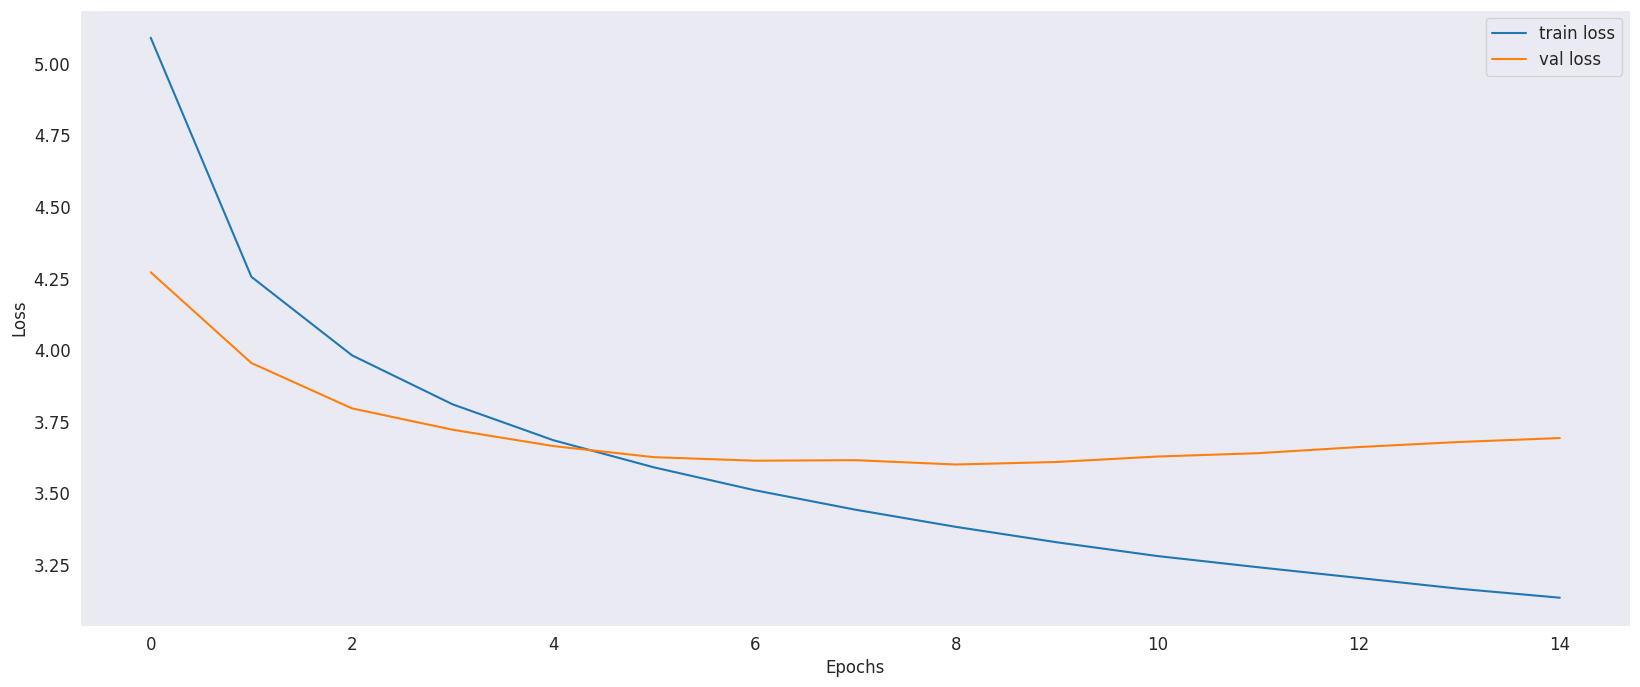

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
import pickle
#Mo file o che do ghi nhi phan
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

fe.save("feature_extractor.keras")

In [15]:
# Đường dẫn tới model đã train, tokenizer đã lưu, và feature extractor
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length =34):
  # ==== LOAD MODEL VÀ TOKENIZER ====
    # Load model captioning (CNN + LSTM)
  caption_model = load_model(model_path)
  # Load feature extractor (DenseNet201 cắt output)
  feature_extractor = load_model(feature_extractor_path)
  # Load tokenizer từ file pickle
  with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)
# ==== XỬ LÝ ẢNH ====
    # Load ảnh, resize về 224x224
  img = load_img(image_path, target_size=(224, 224))
   # Chuyển ảnh thành numpy array
  img = img_to_array(img)
  img = img/255.0
  # Thêm dimension batch (1,224,224,3)
  img = np.expand_dims(img, axis=0)
  # Trích đặc trưng ảnh bằng feature extractor
  img_features = feature_extractor.predict(img, verbose=0)

  in_text = "startseq"
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    # Model dự đoán từ tiếp theo (softmax trên vocab)
    y_hat = caption_model.predict([img_features, sequence], verbose=0)
     # Lấy chỉ số từ có xác suất cao nhất
    y_hat_index = np.argmax(y_hat)
    # Convert index → word qua tokenizer
    word = tokenizer.index_word.get(y_hat_index)
    # Nếu không map được từ thì stop
    if word is None:
      break
     # Thêm từ vào caption
    in_text += " " + word
    # Nếu gặp endseq thì dừng
    if word == "endseq":
      break
          # ==== FORMAT LẠI CAPTION ====
    # Bỏ token "startseq" và "endseq"
  caption = in_text.replace("startseq", "").replace("endseq", "").strip()
  img = load_img(image_path, target_size = (img_size, img_size))
  plt.imshow(img)
  plt.axis("off")
  plt.title(caption, fontsize=16, color='blue')
  plt.show()
